# 第四节 微调和引导

## 你将学到什么？  
1、更快的采样算法 DDIM  
2、

（待完成）

In [2]:
# 访问 https://huggingface.co/settings/tokens 生成有 write 权限的 token 用于登录
from huggingface_hub import notebook_login
notebook_login()

# 运行环境
import os
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# 网络不好，可能需要多尝试几次下载
# 一个下载异常重试的装饰器，对于需要下载的模块避免重复写下载异常判断
import functools

def retry_on_exception(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        while True:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                print(e)
    return wrapper

@retry_on_exception
def load_ddpm_pipeline(model_id, cache_dir, device):
    return DDPMPipeline.from_pretrained(model_id, cache_dir=cache_dir).to(device)

# 模型数据存放路径，默认放在同一个文件夹
model_zoo_dir = r'E:\model_zoo\huggingface\diffusers'

## 4.1 DDIM----更快的采样过程

### 4.1.1 加载一个现有的 DDPM 管线

HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /google/ddpm-celebahq-256/resolve/main/model_index.json (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1007)')))
HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /google/ddpm-celebahq-256/resolve/main/model_index.json (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1007)')))


diffusion_pytorch_model.safetensors not found


  0%|          | 0/1000 [00:00<?, ?it/s]

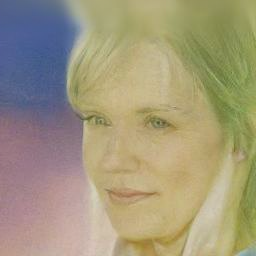

In [2]:
cache_dir = os.path.join(model_zoo_dir, 'ddpm-celebahq-256')

# 加载预设好的DDPM管线
image_pipe = load_ddpm_pipeline('google/ddpm-celebahq-256', cache_dir, device)
images = image_pipe().images

# 看看这个管线是做什么的
images[0]

### 4.1.2 DDIM  
在Diffusers库中，这些采样方法是通过调度器进行控制的，每次更新则是由step()函数来完成的。  
为了生成图像，我们将从随机噪声开始，在每个时间步都将带有噪声的输入送入模型，并将模型的预测结果再次输入step()函数。  
最后，将返回的输出命名为prev_sample，其中，prev表示previous，这是因为我们在时间上其实是倒退的，整个过程是从高噪声到低噪声的（与前向扩散过程相反）。
这个小节载入的调度器是DDIMScheduler（基于论文“Denoising Diffusion Implicit Models”）。  
与DDPM相比，DDIMScheduler可以通过更少的迭代周期来产生很不错的采样样本。

In [3]:
# 创建 DDIM 调度器并设置推理迭代次数
cache_dir = os.path.join(model_zoo_dir, 'ddpm-celebahq-256')
@retry_on_exception
def load_ddim_scheduler(model_id, cache_dir):
    return DDIMScheduler.from_pretrained(model_id, cache_dir=cache_dir)
# 使用和 4.1.1 相同的模型，只是更换调度器
scheduler = load_ddim_scheduler('google/ddpm-celebahq-256', cache_dir)
# 只用 40 步采样，而DDPM 用 1000 步采样
scheduler.set_timesteps(num_inference_steps=40)
# 输出时间步
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

使用4幅随机噪声图像进行循环采样，并观察每一步的输入图像与预测结果的“去噪”版本，代码如下：

0it [00:00, ?it/s]

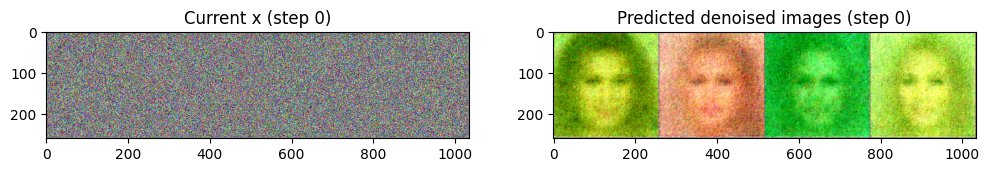

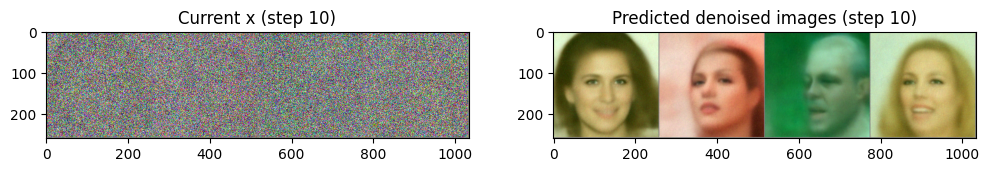

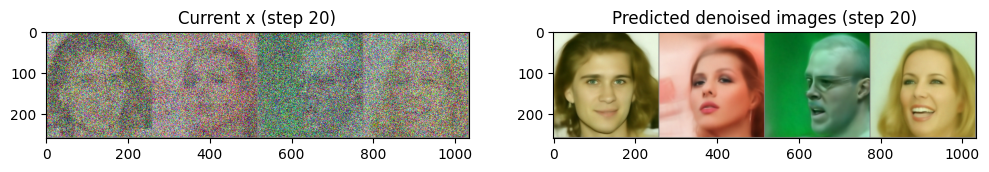

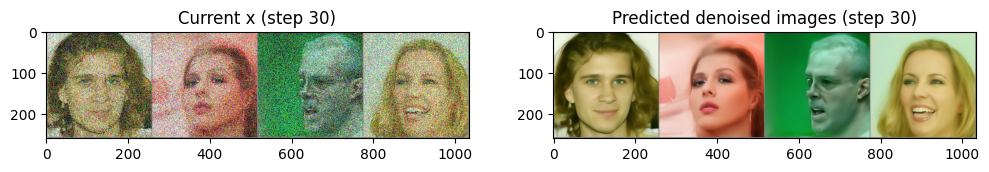

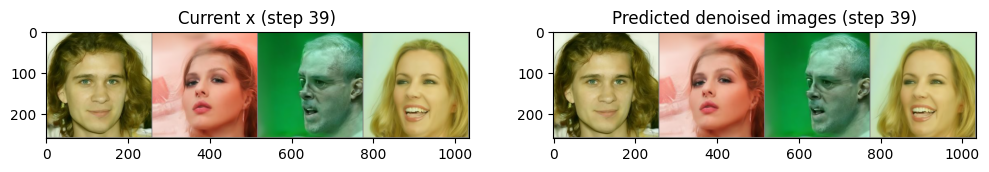

In [4]:
# 从随机噪声开始
x = torch.randn(4, 3, 256, 256).to(device) # batch size为4，三通道，长、宽均为256像素的一组图像
# 循环一整套时间步
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # 准备模型输入：给“带躁”图像加上时间步信息
    model_input = scheduler.scale_model_input(x, t)

    # 预测噪声
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 使用调度器计算更新后的样本应该是什么样子
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新输入图像
    x = scheduler_output.prev_sample

    # 时不时看一下输入图像和预测的“去噪”图像
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        ) 
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

也可以直接使用新的调度器替换原有管线中的调度器，然后调用管线进行采样。

  0%|          | 0/40 [00:00<?, ?it/s]

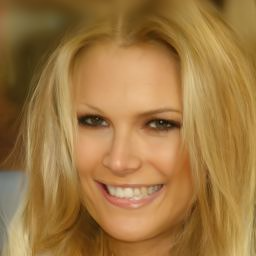

In [5]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

## 4.2 微调

微调可以自定义数据集，为方便使用之前下载的蝴蝶数据集

In [11]:
cache_dir = os.path.join(model_zoo_dir, 'smithsonian_butterflies_subset')
dataset_name = "huggan/smithsonian_butterflies_subset"
@retry_on_exception
def load_dataset_always(dataset_name, cache_dir, split="train"):
    return load_dataset(dataset_name, cache_dir=cache_dir, split=split)
dataset = load_dataset_always(dataset_name, cache_dir=cache_dir)
image_size = 256
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Found cached dataset parquet (E:/model_zoo/huggingface/diffusers/smithsonian_butterflies_subset/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


输出四张图片观察一下

Previewing batch:


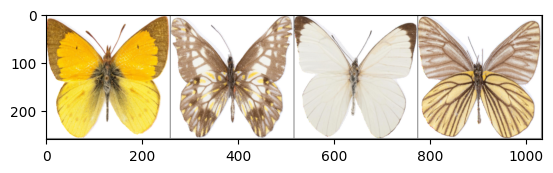

In [12]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

训练，微调之前人脸的模型

  0%|          | 0/250 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\envs\test\lib\site-packages\diffusers\configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.012002393108676188


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.012214774186548311


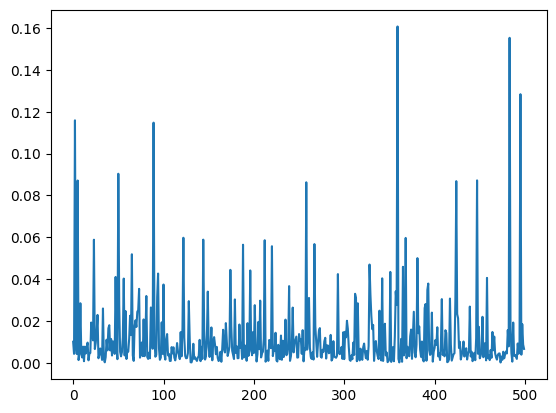

In [13]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []
for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # 随机生成一个噪声，稍后加到图像上
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # 随机选取一个时间步
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # 根据选中的时间步和确定的幅值，在干净图像上添加噪声
        # 此处为前向扩散过程
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)
        # 使用“带噪”图像进行网络预测
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # 对真正的噪声和预测的结果进行比较，注意这里是预测噪声
        loss = F.mse_loss(
            noise_pred, noise
        )

        # 保存损失值
        losses.append(loss.item())

        # 根据损失值更新梯度
        loss.backward()

        # 进行梯度累积，在累积到一定步数后更新模型参数
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )
# 画出损失曲线
plt.plot(losses) 

0it [00:00, ?it/s]

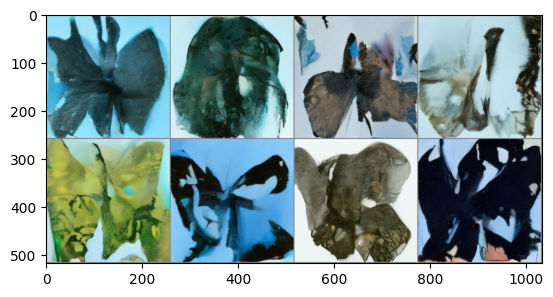

In [14]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)